# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=2000)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 5319, 'TN': 4573, 'FP': 5470, 'FN': 4638, 'Accuracy': 0.4946, 'Precision': 0.49300213180090835, 'Recall': 0.5341970473034047, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9550, 'TN': 9876, 'FP': 167, 'FN': 407, 'Accuracy': 0.9713, 'Precision': 0.9828136256046105, 'Recall': 0.9591242342070905, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10043, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

class sklearn.linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver='auto', random_state=None)

alpha reduces variance, fit_intercept calc the intercept(?), normalize will normalize before regression, copy_x, max_iter number of iterations, tol is the precision of the solution, class weight will change the weights of classes, solver uses different algorithms in computational routines.

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=.3, tol=0.05, class_weight='balanced', solver='sag')
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9860, 'TN': 9930, 'FP': 113, 'FN': 97, 'Accuracy': 0.9895, 'Precision': 0.98866940739998, 'Recall': 0.9902581098724516, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=50, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9734, 'TN': 9619, 'FP': 424, 'FN': 223, 'Accuracy': 0.96765, 'Precision': 0.9582594999015555, 'Recall': 0.9776036958923371, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

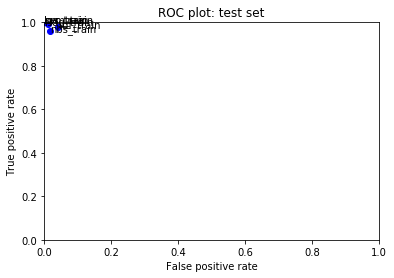

In [12]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
164
the characters at depth-less rip offs. you've seen all the characters in other movies, i promise. the script tries to be edgy and obnoxious but fails miserably. it throws in some hangover meets superbad comedy but the jokes are way out of left field, completely forced, and are disreguarded almost completely after they are cracked. the hot chick is old and has no personality, shes just some early thirties blonde chick with a few wise ass non-underwear wearing jokes who is less than endearing. the attraction between Molly (the hot chick) and Kirk (the dorky love interest) is barely communicated. the attraction in no where to be found its a completely platonic relationship until they awkward and predictable seat belt- mishap kiss occurs. afer this they are in a full on relationship and its just incredibly lame. the main focus of this movie is not the relationship, but a failed attempt at making a raunchy super-bad-esquire movie with a semi appealing plot. 

2673
No likeable characters (the lead is a combination of the WORST of Woody Allen/Paul Provensa/Reiser) and the contrived scenes (did anyone REALLY think thiat kid on the rollerblades was NOT going to knock the guy down?) were just sickeningly bad.<br /><br />
* * * * * * * * * 
2842
I was looking for a cute, simple comedy to pass the time but choosing this film proved to be an enormous mistake.<br /><br />I can't write a single good thing about it. First, the script is stupid and not funny at all, relying on tired, recycled jokes and a farting turtle for laughs. In my book, that's not funny, that's pathetic.<br /><br />Low budget 'effects' (if I can even call them effects) with horrible cinematography. In many places it feels almost like an indie film shot with no money.<br /><br />Acting... I feel sorry for the actors. Are Pamela Anderson and Denise Richards that desperate for some money that they've agreed to take part in this? (looking at their recent filmography, it would appear 

5726
I thank god I didn't go to cinema for this film. I would be very sorry for the money I gave. I saw it on tv and I couldn't beleive my eyes. I wonder if any film could be worse than this one. they spent millions of dollars to this film for nothing. awful acting and awful scenario. I think the other people who wrote comments are the man working from that film company ;) it's very big fiasco! in year 2000 can they still laugh at this kind of film? embarassing...
* * * * * * * * * 
5807
I've waited a long time to see DR TARR'S TORTURE DUNGEON and after I watched it, I was really disappointed by it. It's not the Baroque film I expected it to be. The trailer (which I saw on a Something Weird DVD) is much better than the entire film, which is remarkably forgettable. There are almost no stand out scenes in it and the look and feel is interesting but it doesn't even come close to other Baroque styled movies out there, from Fellini or Jodorowsky. The characters are dull and there's almost n

8232
The long list of \big\" names in this flick (including the ubiquitous John Mills) didn't bowl me over to the extent that I couldn't judge the film on its actual merits. It is FULL of stereotypes, caricatures, and standard, set scenes, from the humble air-ace hero to the loud-mouthed yank flyer. The music track was such that at one point, about an hour before the end, I thought the film was over: loud, rising crescendo, grand flourish and finish then silence, but then the movie continued! I found no real storyline, haphazard writing, but smartly-pressed uniforms and the pretty Jean Simmons (pre-nose job) with a rousing little ditty. I cannot say that this picture has any of the ingredients which make a film great. I found it maudlin, mawkish and minor."
* * * * * * * * * 
8260
Movie industry is tricky business - because decisions have to be made and everyone involved has a private life, too. That's the very original thesis of this feeble attempt at making an 'insightful' film about

11567
Those 2 points are dedicated the reasonable performance from Akshay Kumar. I know Bollywood films do not really strive to be realistic but PLEASE a Walt Disney production is more realistic than this plot. The father is dying and does what any good parent does...kick his son out the son with his PREGNANT wife. A few things that were too hard to swallow- 1. Priyanka 'cool indoor swimming pool in the bedroom' and to go from that to living hungry in her in-laws garden shed???????? 2. Akshay suddenly got the job as a stunt man, gets bitten by rabified dogs, to then just walk off. This film is an INSulT to our intelligence I really cant believe i contributed financially to the 'people' who made this film by taking my family to see it, we left the cinema with a frown, please do not subject yourself to this mess to watching this take my advice and do not waste your 'waqt'.
* * * * * * * * * 
11681
Men In Black 2 was a real disappointment for me. While the actors did a pretty good job, es

14751
Les Visiteurs, the first movie about the medieval time travelers was actually funny. I like Jean Reno as an actor, but there was more. There were unexpected twists, funny situations and of course plain absurdness, that would remind you a little bit of Louis de Funes.<br /><br />Now this sequel has the same characters, the same actors in great part and the same time traveling. The plot changes a little, since the characters now are supposed to be experienced time travelers. So they jump up and down in history, without paying any attention to the fact that it keeps getting absurder as you advance in the movie. The duke, Jean Reno, tries to keep the whole thing together with his playing, but his character has been emptied, so there's not a lot he can do to save the film.<br /><br />Now the duke's slave/helper, he has really all the attention. The movie is merely about him and his being clumsy / annoying / stupid or whatever he was supposed to be. Fact is; this character tries to pro

18208
Snuggle down in your favourite chair and switch on the play-station, as you toss this into the waste disposal unit. Spend a useful 90 min. living your favourite game. Disjointed - poorly filmed - non directed junk. It takes a bits from several other \science fiction\" movies and badly attempts to join the parts into a pathetically weak story. There's nothing new here, the filmmakers do not seem to realise that providing simple entertainment would achieve a monetary game, but a touch of skill ingenuity and flair is required to turn it into a good film. Any money spent watching this is a waste, and personally i would like my 90 min of life back."
* * * * * * * * * 
18211
Let me start by stating that I usually do like Renny Harlin's directing style, for the most part, and that the cinematographer should be commended for some the shots. Unlike Harlin's \Elm Street 4\", and \"Die Hard 2\" which I really liked, there is something that is missing from this movie. That, my friends, is a 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1486, 'TN': 1062, 'FP': 1395, 'FN': 1057, 'Accuracy': 0.5096, 'Precision': 0.5157931273863242, 'Recall': 0.5843491938655132, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2146, 'TN': 2047, 'FP': 410, 'FN': 397, 'Accuracy': 0.8386, 'Precision': 0.8395931142410016, 'Recall': 0.8438851749901691, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2150, 'TN': 2067, 'FP': 390, 'FN': 393, 'Accuracy': 0.8434, 'Precision': 0.8464566929133859, 'Recall': 0.8454581203303185, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1913, 'TN': 1834, 'FP': 623, 'FN': 630, 'Accuracy': 0.7494, 'Precision': 0.7543375394321766, 'Recall': 0.7522611089264648, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2176, 'TN': 2061, 'FP': 396, 'FN': 367, 'Accuracy': 0.8474, 'Precision': 0.8460342146189735, 'Recall': 0.8556822650412899, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2309, 'TN': 2175, 'FP': 282, 'FN': 234, 'Accuracy': 0.8968, 'Precision': 0.8911617136240834, 'Recall': 0.9079826976012584, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1885, 'TN': 1796, 'FP': 661, 'FN': 658, 'Accuracy': 0.7362, 'Precision': 0.7403770620581304, 'Recall': 0.7412504915454188, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

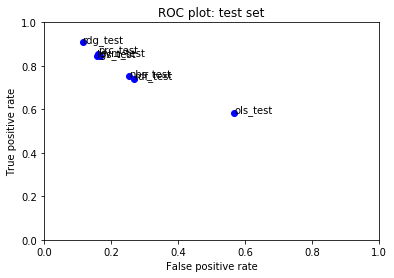

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=200, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49792


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation